In [1]:
import pandas as pd
import math
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
d = pd.read_csv('./train.csv')

In [3]:
# drop unused columns
d = d.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

# drop nan
d = d.dropna()

### Type Casting

In [4]:
d['Pclass'] = pd.to_numeric(d['Pclass']) # cast to int

### Optimizations

In [5]:
# optimizing data

#optimize Age
maxAge = max(d['Age'])
d['Age'] = round(d['Age']/maxAge, 2)

# optimize Fare
d['Fare'] = round(np.log10(d['Fare']+1), 2)

# optimize Pclass
d['Pclass_1'] = np.where(d['Pclass']==1, 1, 0)
d['Pclass_2'] = np.where(d['Pclass']==2, 1, 0)

# optimize gender
d['Sex'] = np.where(d['Sex']=='male',1,0)
d.rename(columns={'Sex' : 'Male'}, inplace=True)

# optimize embarked
d['Embark_S'] = np.where(d['Embarked']=='S',1,0)
d['Embark_C'] = np.where(d['Embarked']=='C',1,0)

# add ones
d['Ones'] = 1

d

,Survived,Pclass,Male,Age,SibSp,Parch,Fare,Embarked,Pclass_1,Pclass_2,Embark_S,Embark_C,Ones
0,0,3,1,0.28,1,0,0.92,S,0,0,1,0,1
1,1,1,0,0.48,1,0,1.86,C,1,0,0,1,1
2,1,3,0,0.32,0,0,0.95,S,0,0,1,0,1
3,1,1,0,0.44,1,0,1.73,S,1,0,1,0,1
4,0,3,1,0.44,0,0,0.96,S,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,0,3,0,0.49,0,5,1.48,Q,0,0,0,0,1
886,0,2,1,0.34,0,0,1.15,S,0,1,1,0,1
887,1,1,0,0.24,0,0,1.49,S,1,0,1,0,1
889,1,1,1,0.32,0,0,1.49,C,1,0,0,1,1


In [6]:
final_data = d[['SibSp', 'Parch', 'Age', 'Fare', 'Pclass_1', 'Pclass_2', 'Embark_S', 'Embark_C', 'Male', 'Ones']]

final_data

,SibSp,Parch,Age,Fare,Pclass_1,Pclass_2,Embark_S,Embark_C,Male,Ones
0,1,0,0.28,0.92,0,0,1,0,1,1
1,1,0,0.48,1.86,1,0,0,1,0,1
2,0,0,0.32,0.95,0,0,1,0,0,1
3,1,0,0.44,1.73,1,0,1,0,0,1
4,0,0,0.44,0.96,0,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...
885,0,5,0.49,1.48,0,0,0,0,0,1
886,0,0,0.34,1.15,0,1,1,0,1,1
887,0,0,0.24,1.49,1,0,1,0,0,1
889,0,0,0.32,1.49,1,0,0,1,1,1


In [7]:
# w = np.array([5,2,3,4,5,6,7,8,9,10])
w = np.array([0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01])

In [8]:
# finding the loss

pred = (final_data*w).sum(axis=1)
loss = (pred - d['Survived']) ** 2
total_loss = loss.sum()
data = {
    'Predictions': pred,
    'Survived': d['Survived'],
    'Loss': loss
}
df = pd.DataFrame(data)

print("Total Loss : ",total_loss)
df

Total Loss :  256.74885543


,Predictions,Survived,Loss
0,0.0520,0,0.002704
1,0.0634,1,0.877220
2,0.0327,1,0.935669
3,0.0617,1,0.880407
4,0.0440,0,0.001936
...,...,...,...
885,0.0797,0,0.006352
886,0.0549,0,0.003014
887,0.0473,1,0.907637
889,0.0581,1,0.887176


### Using Torch for Backprop

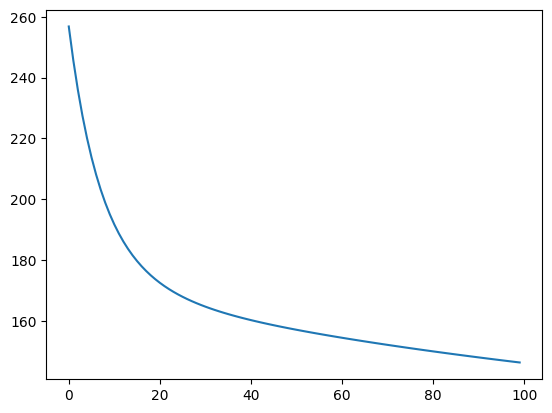

In [70]:
# data
final_data_t = torch.Tensor(final_data.values)       ; final_data_t.requires_grad = True
ground_truth = torch.Tensor(d['Survived'].values)

# weights
w_t = torch.Tensor(w)                                ; w_t.requires_grad = True
G_loss = []

for i in range(100):
    # Forward Pass
    predictions = torch.sum((final_data_t * w_t), dim=1) ;#  predictions.requires_grad = True
    predictions = torch.tanh(predictions)
    
    # loss
    loss = torch.sum((predictions - ground_truth) ** 2)
    # print(i, ' Total Loss: ', loss.data.item())
    G_loss.append(loss.data.item())
    # backward pass
    loss.backward()
    
    # Nudge the gradients
    with torch.no_grad():
        w_t -= 0.00001 * w_t.grad
    
    # Reset Gradients
    w_t.grad.zero_()
plt.plot([i for i in range(len(G_loss))], G_loss)
plt.show()

In [71]:
w_t

tensor([ 0.0067,  0.0503,  0.0333,  0.1744,  0.0832,  0.0513,  0.0469,  0.0628,
        -0.0694,  0.1017], requires_grad=True)